# 1. Problem Desinition


*   Objectives: Develop an anomaly detection model capable of accurately distinguishing abnormal patterns or outliers in the machine temperature dataset.




# 2. Data Collection

*   Data Source: The Numenta Anomaly Benchmark (NAB) is a benchmark designed to evaluate anomaly detection algorithms, particularly for time series data. Created by Numenta, an AI and neuroscience company, NAB provides a standardized framework for testing and comparing the performance of different anomaly detection techniques.

Source Link : https://github.com/numenta/NAB/tree/master/data/realKnownCause






In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot as plt
import os
from sklearn.metrics import f1_score
import scipy.stats as stats
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from tabulate import tabulate
from IPython.display import HTML, display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
df = pd.read_csv('/content/drive/MyDrive/machine_temperature_system_failure.csv')
df.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22695 entries, 0 to 22694
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  22695 non-null  object 
 1   value      22695 non-null  float64
dtypes: float64(1), object(1)
memory usage: 354.7+ KB
None


In [ ]:
#'timestamp' is a string representation of timestamps, convert it to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22695 entries, 0 to 22694
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  22695 non-null  datetime64[ns]
 1   value      22695 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 354.7 KB
None


This approach helps in converting the timestamp column to a consistent datetime format in the dataset.

# 3. Data Preprocessing

In [ ]:
# Check for missing values in the timestamp column
missing_timestamps = df[df['timestamp'].isnull()]
if missing_timestamps.empty:
    print("No missing timestamps.")
else:
    print("Missing timestamps detected:")
    print(missing_timestamps)


No missing timestamps.


Dataset from the NAB repository includes labeled anomalies.


Anomaly points information using this link: https://github.com/numenta/NAB/blob/master/labels/combined_windows.json

 "realKnownCause/machine_temperature_system_failure.csv": [
        [
            "2013-12-10 06:25:00.000000",
            "2013-12-12 05:35:00.000000"
        ],
        [
            "2013-12-15 17:50:00.000000",
            "2013-12-17 17:00:00.000000"
        ],
        [
            "2014-01-27 14:20:00.000000",
            "2014-01-29 13:30:00.000000"
        ],
        [
            "2014-02-07 14:55:00.000000",
            "2014-02-09 14:05:00.000000"
        ]
    ],

In [ ]:
# Define anomaly point
anomaly_points = [
        ["2013-12-10 06:25:00.000000","2013-12-12 05:35:00.000000"],
        ["2013-12-15 17:50:00.000000","2013-12-17 17:00:00.000000"],
        ["2014-01-27 14:20:00.000000","2014-01-29 13:30:00.000000"],
        ["2014-02-07 14:55:00.000000","2014-02-09 14:05:00.000000"]
]

In [ ]:
# Is anomaly? : True => 1, False => 0
df['anomaly'] = 0
for start, end in anomaly_points:
    df.loc[((df['timestamp'] >= start) & (df['timestamp'] <= end)), 'anomaly'] = 1

In [ ]:
# Datetime Information

df['year'] = df['timestamp'].apply(lambda x : x.year)
df['month'] = df['timestamp'].apply(lambda x : x.month)
df['day'] = df['timestamp'].apply(lambda x : x.day)
df['hour'] = df['times amp'].apply(lambda x : x.hour)
df['minute'] = df['timestamp'].apply(lambda x : x.minute)

In [ ]:
df.index = df['timestamp']
df.drop(['timestamp'], axis=1, inplace=True)
df.head()

,value,anomaly,year,month,day,hour,minute
timestamp,,,,,,,
2013-12-02 21:15:00,73.967322,0,2013,12,2,21,15
2013-12-02 21:20:00,74.935882,0,2013,12,2,21,20
2013-12-02 21:25:00,76.124162,0,2013,12,2,21,25
2013-12-02 21:30:00,78.140707,0,2013,12,2,21,30
2013-12-02 21:35:00,79.329836,0,2013,12,2,21,35


# 4. Exploratory Data Analysis (EDA)




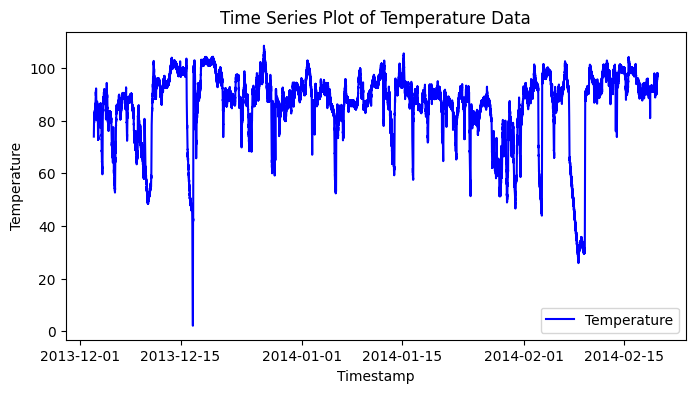

In [ ]:
# Plotting the time series data
plt.figure(figsize=(8, 4))
plt.plot(df.index, df['value'], label='Temperature', color='blue')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.title('Time Series Plot of Temperature Data')
plt.legend()
plt.show()

* This time series plot showcasing the temperature variations over time.
* The plot shows the temperature variations over time, allowing you to observe trends, periodicities, or any evident anomalies.



In [ ]:
# Calculate statistical measures
mean_temp = df['value'].mean()
std_dev_temp = df['value'].std()

# Display descriptive statistics
print(f"Mean Temperature: {mean_temp:.2f}")
print(f"Standard Deviation: {std_dev_temp:.2f}")

# Explore percentile values
percentiles = [0.25, 0.50, 0.75]
temp_percentiles = df['value'].quantile(percentiles)
print("Temperature Percentiles:")
print(temp_percentiles)


Mean Temperature: 85.93
Standard Deviation: 13.75
Temperature Percentiles:
0.25    83.080078
0.50    89.408246
0.75    94.016252
Name: value, dtype: float64


* Statistical measures such as mean, standard deviation, and selected percentiles (25th, 50th, 75th) to understand the distribution and central tendencies of the temperature data.
* Mean temperature provides insight into the average, while standard deviation indicates the variability of temperature values. Percentiles reveal the distribution's quartiles.

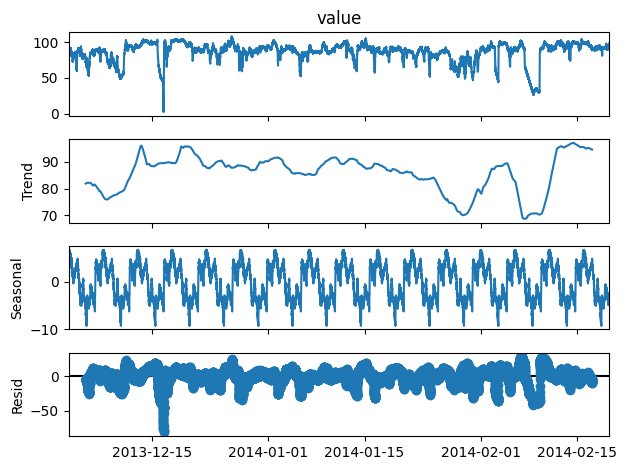

In [ ]:
# Seasonal decomposition (assuming 'value' is the temperature column)
result = seasonal_decompose(df['value'], model='additive', period=24*60)  # Assuming daily seasonality

# Plot the decomposition
result.plot()
plt.show()

* Decomposes the time series into its trend, seasonal, and residual components, aiding in understanding long-term trends and cyclic patterns.

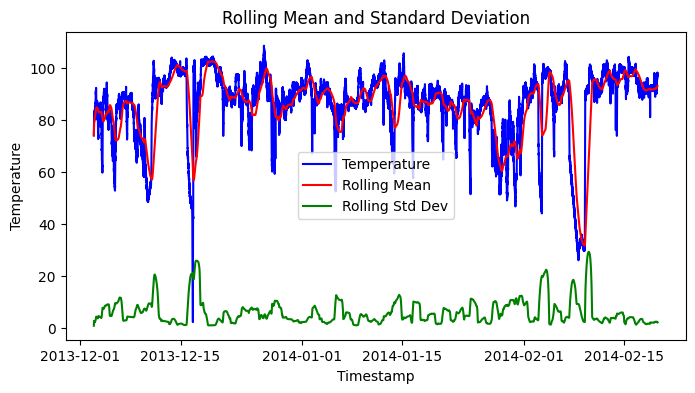

In [ ]:
# Calculate rolling mean and standard deviation
rolling_mean = df['value'].rolling(window=12*24, min_periods=1).mean()  # 24-hour rolling window
rolling_std = df['value'].rolling(window=12*24, min_periods=1).std()

# Plot rolling statistics
plt.figure(figsize=(8, 4))
plt.plot(df.index, df['value'], label='Temperature', color='blue')
plt.plot(df.index, rolling_mean, label='Rolling Mean', color='red')
plt.plot(df.index, rolling_std, label='Rolling Std Dev', color='green')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.title('Rolling Mean and Standard Deviation')
plt.legend()
plt.show()


* Plots showing the rolling mean and standard deviation, offering insights into trends and variations over a defined window size.

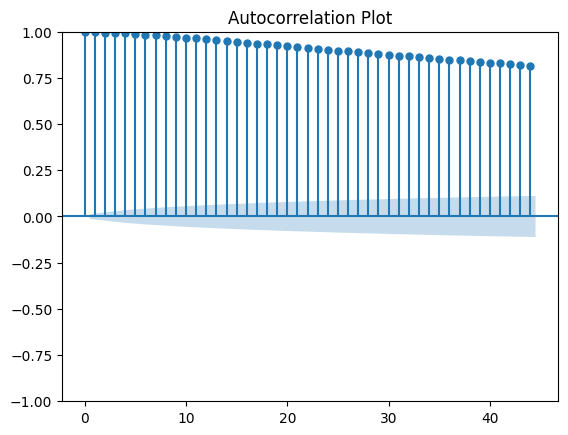

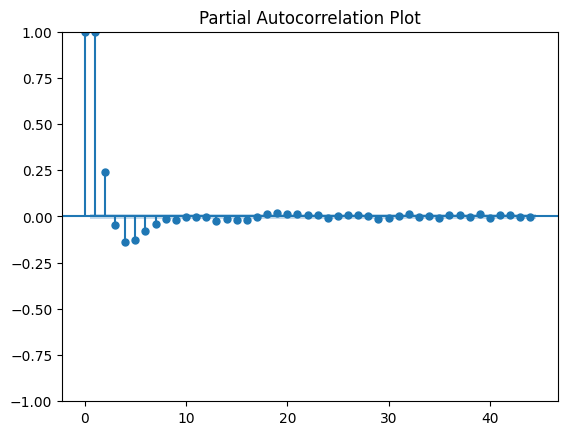

In [ ]:
# Autocorrelation plot
plot_acf(df['value'])
plt.title('Autocorrelation Plot')
plt.show()

# Partial Autocorrelation plot
plot_pacf(df['value'])
plt.title('Partial Autocorrelation Plot')
plt.show()

* These plots help identify the correlation between the time series and its lagged versions, aiding in understanding potential dependencies and seasonality.

<Figure size 800x400 with 0 Axes>

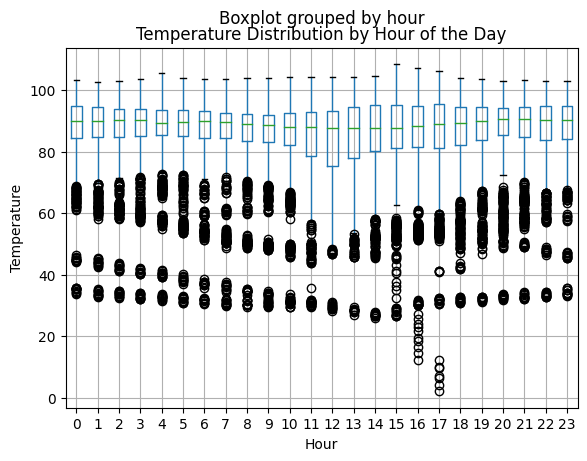

In [ ]:
df['hour'] = df.index.hour  # Extracting hour from the timestamp

# Boxplot of temperature distribution by hour
plt.figure(figsize=(8, 4))
df.boxplot(column='value', by='hour')
plt.title('Temperature Distribution by Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Temperature')
plt.show()

* Boxplots showing the temperature distribution for different hours, revealing hourly variations.

# 5. Model Selection





Selecting an appropriate anomaly detection algorithm for time series data involves considering various factors such as the dataset's characteristics, the nature of anomalies, and computational efficiency.

1. Standard Deviation Method: Simple and effective for detecting anomalies based on deviation from the mean. Identifies outliers using statistical thresholds.

2. One-Class SVM (Support Vector Machines): Learns the boundaries of normal instances and detects deviations. Particularly effective when the dataset is unbalanced with a majority of normal instances.

3. Isolation Forest: Suitable for high-dimensional data. Efficiently isolates anomalies by randomly partitioning the data, making it effective for detecting outliers.

4. Variance Based Method: This is variance based method with assumption of the normal distribution against the data.

# 6. Model Training

## 1. Standard Deviation Method

In [ ]:
train_df = pd.DataFrame()
train_df['value'] = df['value']
mean = train_df['value'].mean()
std = train_df['value'].std()
train_df['anomaly_score'] = [((x - mean)/std) ** 2 for x in train_df['value']]
train_df['anomaly_threshold'] = stats.chi2.ppf(q=0.95, df=1)
train_df['anomaly']  = train_df.apply(lambda x : 1 if x['anomaly_score'] > x['anomaly_threshold'] else 0, axis=1)

In [ ]:
train_f1 = f1_score(df['anomaly'], train_df['anomaly'])
print(f'F1 Score : {train_f1}')

F1 Score : 0.5440778799351


## 2. One-Class SVM (Support Vector Machines)

In [ ]:
ocsvm_model = OneClassSVM(nu=0.2, gamma=0.001, kernel='rbf')
ocsvm_ret = ocsvm_model.fit_predict(df['value'].values.reshape(-1, 1))
ocsvm_df = pd.DataFrame()
ocsvm_df['value'] = df['value']
ocsvm_df['anomaly']  = [1 if i==-1 else 0 for i in ocsvm_ret]

In [ ]:
ocsvm_f1 = f1_score(df['anomaly'], ocsvm_df['anomaly'])
print(f'One-Class SVM F1 Score : {ocsvm_f1}')

One-Class SVM F1 Score : 0.4224441833137485


## 3. Isolation Forest



In [ ]:
iforest_model = IsolationForest(n_estimators=300, contamination=0.1, max_samples=700)
iforest_ret = iforest_model.fit_predict(df['value'].values.reshape(-1, 1))
iforest_df = pd.DataFrame()
iforest_df['value'] = df['value']
iforest_df['anomaly']  = [1 if i==-1 else 0 for i in iforest_ret]

In [ ]:
iforest_f1 = f1_score(df['anomaly'], iforest_df['anomaly'])
print(f'Isolation Forest F1 Score : {iforest_f1}')

Isolation Forest F1 Score : 0.5279858968708683


## 4. Variance Based Method

In [ ]:
var_df = pd.DataFrame()
var_df['value'] = df['value']
std = var_df['value'].std()
var_df['anomaly_threshold_3r'] = mean + 1.5*std
var_df['anomaly_threshold_3l'] = mean - 1.5*std
var_df['anomaly']  = var_df.apply(lambda x : 1 if (x['value'] > x['anomaly_threshold_3r']) or (x['value'] < x['anomaly_threshold_3l']) else 0, axis=1)

In [ ]:
var_f1 = f1_score(df['anomaly'], var_df['anomaly'])
print(f'Variance Based Method F1 Score : {var_f1}')

Variance Based Method F1 Score : 0.585277463193658


# 7. Model Evaluation




In [ ]:
display(HTML('<h3>Evaluation - F1 Score</h3>'+tabulate([['F1 Score', train_f1, ocsvm_f1, iforest_f1,  var_f1]],\
                      ["", "train", "One-Class SVM", 'Isolation Forest', 'Variance Based Method'], tablefmt="html")))

,train,One-Class SVM,Isolation Forest,Variance Based Method
F1 Score,0.544078,0.422444,0.527986,0.585277


# 8. Conclusion

* The model built with simple algorithms resulted in high accuracy.
* It is considered that a simple algorithm is effective in many cases for time-series data having a simple structure such as a constant mean and variance over time.
* Complex and robust algorithms are considered to be effective when time-series has complicated patterns or when there are various anomolous patterns.
* In this analysis, the model was evaluated based on the F1 score, but if you want to make a more business-oriented evaluation, the following viewpoints should be added to the evaluation.
* Detection of signs of anomalies
* Balance of importance of false positive and false negative
Model interpretability
